In [ ]:
## plot EKE relative to rolling

In [1]:
import os

import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs
import cmocean as cm
from xgcm import Grid
import glob

import matplotlib.dates as mdates
import datetime
import pandas as pd

In [2]:
%matplotlib inline

In [101]:
from matplotlib import rc
rc('font', **{'size':25})
rc('text', usetex=False)
rc('xtick', labelsize=25) #20 
rc('ytick', labelsize=25) #20
rc('axes', titlesize=25)    # fontsize of the axes title
rc('axes', labelsize=25) #24    # fontsize of the x and y labels

In [4]:
session=cc.database.create_session()

exp_ctrl= '01deg_jra55v13_ryf9091'
exp_wthmp= '01deg_jra55v13_ryf9091_qian_wthmp'
exp_wthp= '01deg_jra55v13_ryf9091_qian_wthp'
lat_lim = slice(-79, -60)
lon_lim = slice(-279.99,80)

#### SET EXPT HERE
expt = exp_ctrl


In [5]:
# We will use an annual average from 10 year in the RYF run
start_time_mw='2110-01-31 00:00:00' 
end_time_mw='2159-12-31 00:00:00'
start_time='1950-01-31 00:00:00'
end_time='1959-12-31 00:00:00'


In [62]:
import dask.config
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

walltime = '03:00:00'
cores = 28
memory = '252GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory),processes=cores,
                     job_extra=['-q normalbw','-P v45','-l ncpus='+str(cores),'-l mem='+str(memory),
                                '-l storage=gdata/ik11+gdata/e14+gdata/hh5+gdata/v45+gdata/cj50',
                                '-l jobfs=400GB'],
                     local_directory='$TMPDIR',
                     header_skip=["select"],
                     #python=os.environ["DASK_PYTHON"]
                    )
cluster

# and if you want even more power, you can use this to make it three nodes
cluster.scale(jobs=3)

# then, run this to make a dask client

c = Client(cluster)
c

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/35769/status,
Dashboard: /proxy/35769/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.27:45383,Workers: 0
Dashboard: /proxy/35769/status,Total threads: 0
Started: Just now,Total memory: 0 B


Task exception was never retrieved
future: <Task finished name='Task-1716274' coro=<Client._gather.<locals>.wait() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:2197> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py", line 2206, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-2860900' coro=<Client._gather.<locals>.wait() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:2197> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py", line 2206, in wait
    raise AllExit()
distributed.client.AllExit


In [7]:
windows = 120

In [86]:
hu = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='hu', 
                          session=session, frequency='static',
                          attrs={'cell_methods': 'time: point'}, n=1).sel(yu_ocean = slice(-79,-60))
hu

<xarray.DataArray 'hu' (yu_ocean: 440, xu_ocean: 3600)> Size: 6MB
dask.array<getitem, shape=(440, 3600), dtype=float32, chunksize=(440, 900), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02
    geolon_c  (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    geolat_c  (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
Attributes:
    long_name:     ocean depth on u-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point
    ncfiles:       ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf909...
    contact:       Andy Hogg
    email:         andy.hogg@anu.edu.au
    created:       2020-06-11
    description:   0.1 degree ACCESS-OM2 global model configuration with JRA5...
    notes:         Additional daily outputs saved from 1 Jan 1950 to 31 Dec 1...
    url:           https://github.com/COSIMA/01deg_jra55_ryf/tree/01deg_jra55...

In [8]:
# NEEDload coordinates and grid specifications
geolat_t = cc.querying.getvar(expt, 'geolat_t', session=session, n=1)
geolon_t = cc.querying.getvar(expt, 'geolon_t', session=session, n=1)

dxt = cc.querying.getvar(expt=expt, variable='dxt', session=session, frequency='static', n=1)
dyt = cc.querying.getvar(expt=expt, variable='dyt', session=session, frequency='static', n=1)

dxu = cc.querying.getvar(expt=expt, variable='dxu', session=session, frequency='static', n=1)
dyu = cc.querying.getvar(expt=expt, variable='dyu', session=session, frequency='static', n=1)

In [9]:
flex_period = slice(start_time_mw,end_time_mw)
flex_period = slice('2110','2159')

In [10]:
#sea_level_lim = sea_level.sel( xt_ocean= lon_lim, yt_ocean=lat_lim, time = flex_period)

# coordinates
lat_t = geolat_t.sel( xt_ocean= lon_lim,yt_ocean=lat_lim)
lon_t = geolon_t.sel(xt_ocean= lon_lim, yt_ocean=lat_lim)

dxt_lim = dxt.sel(xt_ocean= lon_lim,yt_ocean=lat_lim)
dyt_lim = dyt.sel(xt_ocean= lon_lim,yt_ocean=lat_lim)

dxu_lim = dxu.sel(xu_ocean= lon_lim,yu_ocean=lat_lim)
dyu_lim = dyu.sel(xu_ocean= lon_lim,yu_ocean=lat_lim)

In [11]:
u = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/u_monthly_field' + expt +'.nc').ug_s
v = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/v_monthly_field' + expt +'.nc').vg_s

In [12]:
# defining B-grid using xgcm
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
ocean_grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

In [13]:
## need to run seperately or it will crash
import xgcm
coordinates = xr.merge([dxt_lim, dyt_lim, dxu_lim, dyu_lim])

# merge coordinates and variables in one dataset
#vel = xr.merge([coordinates, sea_level_lim.sel(time=flex_period), ocean_grid.sel(time = flex_period)])# time is flex_period before
#vel = xr.merge([coordinates, sea_level_lim.sel(time=flex_period)])#, ocean_grid.sel(time = flex_period)])# time is flex_period before

In [14]:
vel = xr.merge([coordinates, u.sel(time=flex_period), v.sel(time=flex_period), ocean_grid.sel(xt_ocean= lon_lim,xu_ocean= lon_lim, yt_ocean=lat_lim, yu_ocean = lat_lim).isel(time = 0)],compat='override')# time is flex_period before

In [15]:
vel

<xarray.Dataset> Size: 15GB
Dimensions:     (xt_ocean: 3600, yt_ocean: 440, xu_ocean: 3600, yu_ocean: 440,
                 time: 600)
Coordinates:
  * xt_ocean    (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean    (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.1 -60.05
    geolon_t    (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    geolat_t    (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
  * xu_ocean    (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean    (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02
    geolon_c    (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    geolat_c    (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
  * time        (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
Data variables: (12/13)
    dxt         (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    dyt         (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    dxu         (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    dyu         (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    ug_s        (yu_ocean, xu_ocean, time) float64 8GB dask.array<chunksize=(440, 3600, 600), meta=np.ndarray>
    vg_s        (yu_ocean, xu_ocean, time) float64 8GB dask.array<chunksize=(440, 3600, 600), meta=np.ndarray>
    ...          ...
    hu          (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    area_t      (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    area_u      (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    kmt         (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    kmu         (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    drag_coeff  (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
Attributes:
    long_name:     ocean dxt on t-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point
    ncfiles:       ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf909...
    contact:       Andy Hogg
    email:         andy.hogg@anu.edu.au
    created:       2020-06-11
    description:   0.1 degree ACCESS-OM2 global model configuration with JRA5...
    notes:         Additional daily outputs saved from 1 Jan 1950 to 31 Dec 1...
    url:           https://github.com/COSIMA/01deg_jra55_ryf/tree/01deg_jra55...

In [16]:
vel.coords['xt_ocean'].attrs.update(axis='X')
vel.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5, periodic=False)
vel.coords['yt_ocean'].attrs.update(axis='Y')
vel.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
metrics = {
    ('X',): ['dxt', 'dxu'], # X distances
    ('Y',): ['dyt', 'dyu'], # Y distances
    ('X', 'Y'): ['area_t', 'area_u'] # Areas
}

In [17]:
grid = xgcm.Grid(vel, periodic=False, metrics = metrics,boundary='extend')
grid

<xgcm.Grid>
X Axis (not periodic, boundary='extend'):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (not periodic, boundary='extend'):
  * center   yt_ocean --> right
  * right    yu_ocean --> center

In [ ]:
## checking u + v  behaviour circumpolarly over time
FileList = ['/g/data/v45/qo9901/MW-perturb-ASC-data/u_rolling_mean_W' \
            + str(windows) + '_' + exp_wthmp +'_' + '{0:01}'.format(i) + '.nc' for i in range(4)]
u_rolling_mean_W = xr.open_mfdataset(FileList, combine = 'by_coords')


In [30]:
grid.integrate(u_rolling_mean_W, axis = {'X','Y'})

<xarray.Dataset> Size: 8kB
Dimensions:                        (time: 481)
Coordinates:
  * time                           (time) object 4kB 2115-01-16 12:00:00 ... ...
Data variables:
    __xarray_dataarray_variable__  (time) float64 4kB dask.array<chunksize=(481,), meta=np.ndarray>

In [59]:
cluster_mask_access = xr.open_mfdataset('Antarctic-Eddy-Res-Compare/largest_3cluster_mask_xr_accessom201.nc')

In [60]:
def exp_rolling_u_v(expt):
    FileList = ['/g/data/v45/qo9901/MW-perturb-ASC-data/u_rolling_mean_W' \
            + str(windows) + '_' + expt +'_' + '{0:01}'.format(i) + '.nc' for i in range(4)]
    u_rolling_mean_W = xr.open_mfdataset(FileList, combine = 'by_coords')
    FileList = ['/g/data/v45/qo9901/MW-perturb-ASC-data/v_rolling_mean_W' \
            + str(windows) + '_' + expt +'_' + '{0:01}'.format(i) + '.nc' for i in range(4)]
    v_rolling_mean_W = xr.open_mfdataset(FileList, combine = 'by_coords')
    u_t = grid.integrate(u_rolling_mean_W.where(cluster_mask_access == True), axis = {'X','Y'}).load()
    v_t = grid.integrate(v_rolling_mean_W.where(cluster_mask_access == True), axis = {'X','Y'}).load()
    return u_t,v_t

In [19]:
def exp_rolling_speed(expt):
    FileList = ['/g/data/v45/qo9901/MW-perturb-ASC-data/u_rolling_mean_W' \
            + str(windows) + '_' + expt +'_' + '{0:01}'.format(i) + '.nc' for i in range(4)]
    u_rolling_mean_W = xr.open_mfdataset(FileList, combine = 'by_coords')
    FileList = ['/g/data/v45/qo9901/MW-perturb-ASC-data/v_rolling_mean_W' \
            + str(windows) + '_' + expt +'_' + '{0:01}'.format(i) + '.nc' for i in range(4)]
    v_rolling_mean_W = xr.open_mfdataset(FileList, combine = 'by_coords')
    #u_t = grid.integrate(u_rolling_mean_W, axis = {'X','Y'}).load()
    #v_t = grid.integrate(v_rolling_mean_W, axis = {'X','Y'}).load()
    return u_rolling_mean_W,v_rolling_mean_W

In [63]:
u_int_rolling_wthmp, v_int_rolling_wthmp = exp_rolling_u_v(exp_wthmp)
u_int_rolling_wthp, v_int_rolling_wthp = exp_rolling_u_v(exp_wthp)
#u_int_rolling_ryf, v_int_rolling_ryf = exp_rolling_u_v(exp_ryf)

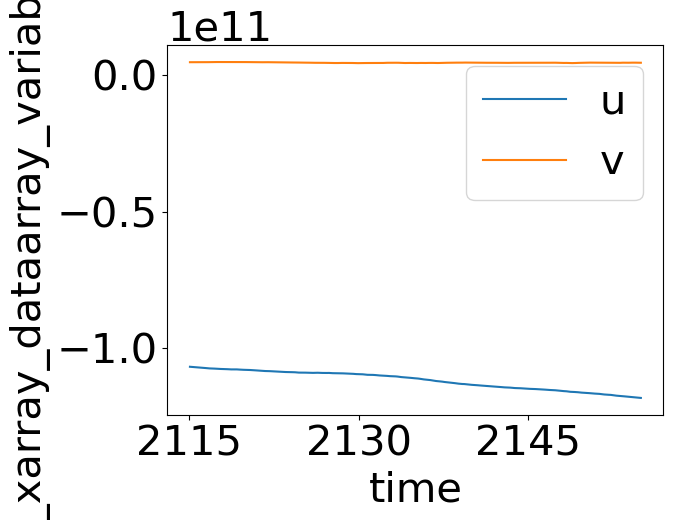

In [64]:
u_int_rolling_wthp.__xarray_dataarray_variable__.plot(label = 'u')
v_int_rolling_wthp.__xarray_dataarray_variable__.plot(label = 'v')
plt.legend()

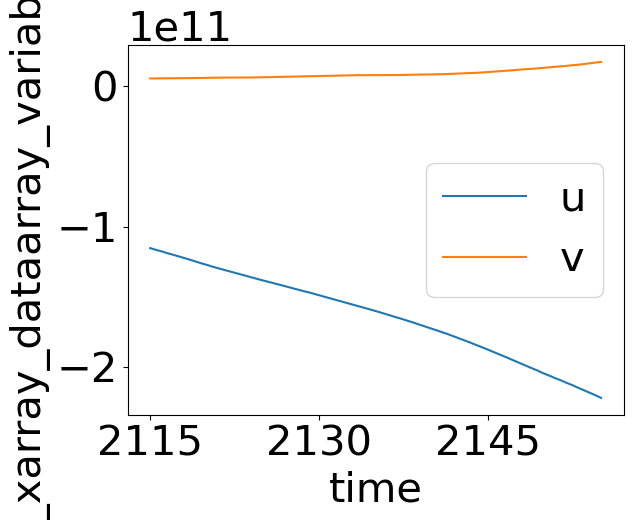

In [65]:
u_int_rolling_wthmp.__xarray_dataarray_variable__.plot(label = 'u')
v_int_rolling_wthmp.__xarray_dataarray_variable__.plot(label = 'v')

plt.legend()

In [20]:
u_rolling_mean_W,v_rolling_mean_W = exp_rolling_speed(exp_wthmp)
u_rolling_mean_W,v_rolling_mean_W

(<xarray.Dataset> Size: 6GB
 Dimensions:                        (yu_ocean: 440, xu_ocean: 3600, time: 481)
 Coordinates:
   * yu_ocean                       (yu_ocean) float64 4kB -78.98 ... -60.02
   * xu_ocean                       (xu_ocean) float64 29kB -279.9 ... 80.0
   * time                           (time) object 4kB 2115-01-16 12:00:00 ... ...
 Data variables:
     __xarray_dataarray_variable__  (yu_ocean, xu_ocean, time) float64 6GB dask.array<chunksize=(440, 900, 481), meta=np.ndarray>,
 <xarray.Dataset> Size: 6GB
 Dimensions:                        (yu_ocean: 440, xu_ocean: 3600, time: 481)
 Coordinates:
   * yu_ocean                       (yu_ocean) float64 4kB -78.98 ... -60.02
   * xu_ocean                       (xu_ocean) float64 29kB -279.9 ... 80.0
   * time                           (time) object 4kB 2115-01-16 12:00:00 ... ...
 Data variables:
     __xarray_dataarray_variable__  (yu_ocean, xu_ocean, time) float64 6GB dask.array<chunksize=(440, 900, 481), meta=np.nd

In [30]:
speed = []
for ii in range(6):
    speed_x = np.sqrt(u_rolling_mean_W.isel(xu_ocean = slice(ii*600, (ii+1)*600),time = slice(30,60))**2 + \
                      v_rolling_mean_W.isel(xu_ocean = slice(ii*600, (ii+1)*600),time = slice(30,60))**2).load()
    speed.append(speed_x)

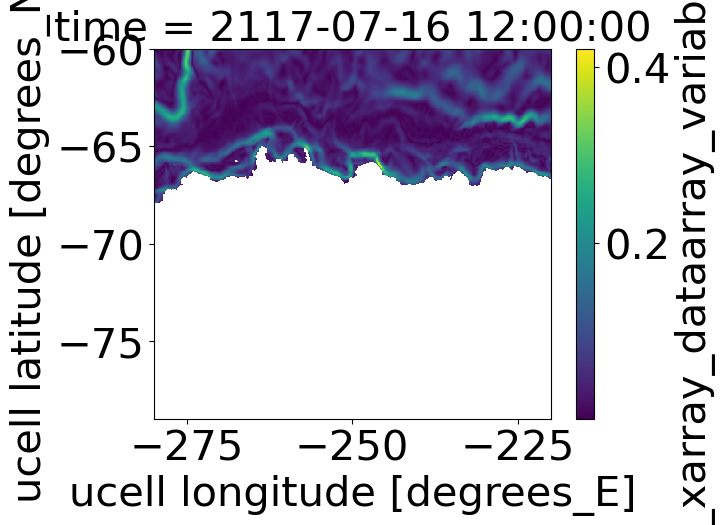

In [27]:
speed[0].__xarray_dataarray_variable__.isel(time = 0).plot()

In [31]:
speed_full = xr.merge(speed)

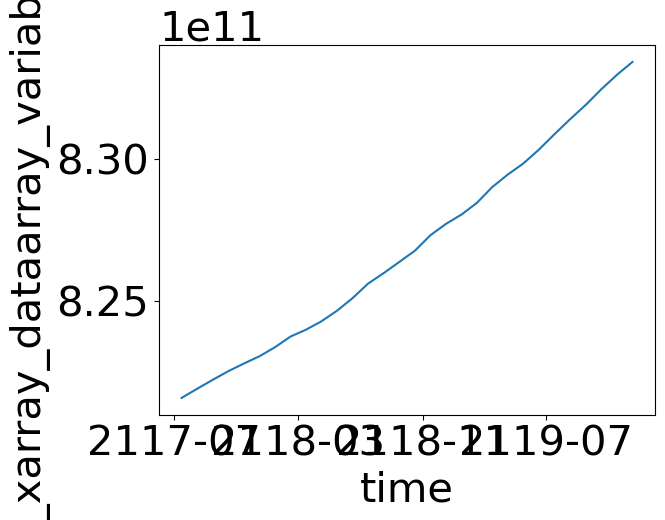

In [32]:
speed_t = grid.integrate(speed_full, axis = {'X','Y'})
speed_t.__xarray_dataarray_variable__.plot()

In [81]:
def speed_timeseries_calculation(expt):
    u_rolling_mean_W, v_rolling_mean_W = exp_rolling_speed(expt)
    speed_t_arr = []
    for tt in range(481):
        speed = []
        for ii in range(6):
            ## calculate speed for subset of x and time 
            speed_x = np.sqrt(u_rolling_mean_W.isel(xu_ocean = slice(ii*600, (ii+1)*600),time = tt)**2 + \
                              v_rolling_mean_W.isel(xu_ocean = slice(ii*600, (ii+1)*600),time = tt)**2).load()
            speed.append(speed_x)
            print(ii)
            del speed_x
        ## merge to get circumpolat picture
        speed_full = xr.merge(speed)
        del speed
        # spatially integrate for subset of time period
        speed_t = grid.integrate(speed_full.where(cluster_mask_access == True), axis = {'X','Y'}).load()
        speed_t_arr.append(speed_t)
        del speed_t
        print('done tt = ' + str(tt))
    speed_t_arr_dim = [speed_t_arr[i].expand_dims('time') for i in range(1)]
    return xr.merge(speed_t_arr_dim)

In [82]:
speed_t_wthmp = speed_timeseries_calculation(exp_wthmp)

0
1
2
3
4
5
done tt = 0
0
1
2
3
4
5
done tt = 1
0
1
2
3
4
5
done tt = 2
0
1
2
3
4
5
done tt = 3
0
1
2
3
4
5
done tt = 4
0
1
2
3
4
5
done tt = 5
0
1
2
3
4
5
done tt = 6
0
1
2
3
4
5
done tt = 7
0
1
2
3
4
5
done tt = 8
0
1
2
3
4
5
done tt = 9
0
1
2
3
4
5
done tt = 10
0
1
2
3
4
5
done tt = 11
0
1
2
3
4
5
done tt = 12
0
1
2
3
4
5
done tt = 13
0
1
2
3
4
5
done tt = 14
0
1
2
3
4
5
done tt = 15
0
1
2
3
4
5
done tt = 16
0
1
2
3
4
5
done tt = 17
0
1
2
3
4
5
done tt = 18
0
1
2
3
4
5
done tt = 19
0
1
2
3
4
5
done tt = 20
0
1
2
3
4
5
done tt = 21
0
1
2
3
4
5
done tt = 22
0
1
2
3
4
5
done tt = 23
0
1
2
3
4
5
done tt = 24
0
1
2
3
4
5
done tt = 25
0
1
2
3
4
5
done tt = 26
0
1
2
3
4
5
done tt = 27
0
1
2
3
4
5
done tt = 28
0
1
2
3
4
5
done tt = 29
0
1
2
3
4
5
done tt = 30
0
1
2
3
4
5
done tt = 31
0
1
2
3
4
5
done tt = 32
0
1
2
3
4
5
done tt = 33
0
1
2
3
4
5
done tt = 34
0
1
2
3
4
5
done tt = 35
0
1
2
3
4
5
done tt = 36
0
1
2
3
4
5
done tt = 37
0
1
2
3
4
5
done tt = 38
0
1
2
3
4
5
done tt = 39
0
1
2
3
4


KeyboardInterrupt: 

In [ ]:
%%time
speed_t_wthp = speed_timeseries_calculation(exp_wthp)

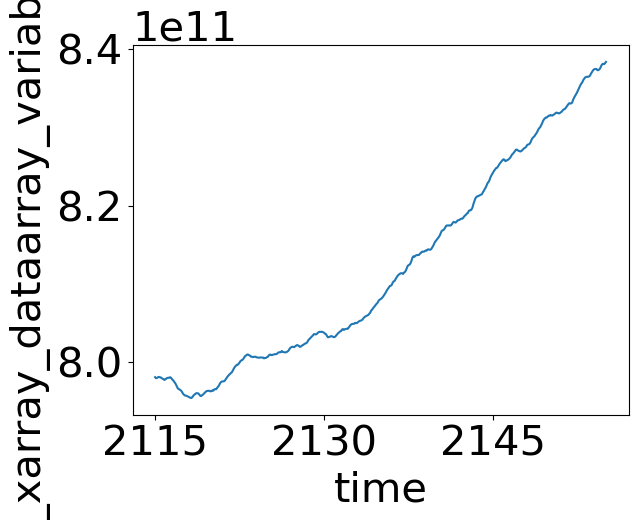

In [53]:
#speed_t_wthmp.__xarray_dataarray_variable__.plot()
speed_t_wthp.__xarray_dataarray_variable__.plot()

In [38]:
speed_t_arr = []
for tt in range(481):
    speed = []
    for ii in range(6):
        ## calculate speed for subset of x and time 
        speed_x = np.sqrt(u_rolling_mean_W.isel(xu_ocean = slice(ii*600, (ii+1)*600),time = tt)**2 + \
                          v_rolling_mean_W.isel(xu_ocean = slice(ii*600, (ii+1)*600),time = tt)**2).load()
        speed.append(speed_x)
        print(ii)
        del speed_x
    ## merge to get circumpolat picture
    speed_full = xr.merge(speed)
    del speed
    # spatially integrate for subset of time period
    speed_t = grid.integrate(speed_full, axis = {'X','Y'}).load()
    speed_t_arr.append(speed_t)
    del speed_t
    print('done tt = ' + str(tt))

0
1
2
3
4
5
done tt = 0
0
1
2
3
4
5
done tt = 1
0
1
2
3
4
5
done tt = 2
0
1
2
3
4
5
done tt = 3
0
1
2
3
4
5
done tt = 4
0
1
2
3
4
5
done tt = 5
0
1
2
3
4
5
done tt = 6
0
1
2
3
4
5
done tt = 7
0
1
2
3
4
5
done tt = 8
0
1
2
3
4
5
done tt = 9
0
1
2
3
4
5
done tt = 10
0
1
2
3
4
5
done tt = 11
0
1
2
3
4
5
done tt = 12
0
1
2
3
4
5
done tt = 13
0
1
2
3
4
5
done tt = 14
0
1
2
3
4
5
done tt = 15
0
1
2
3
4
5
done tt = 16
0
1
2
3
4
5
done tt = 17
0
1
2
3
4
5
done tt = 18
0
1
2
3
4
5
done tt = 19
0
1
2
3
4
5
done tt = 20
0
1
2
3
4
5
done tt = 21
0
1
2
3
4
5
done tt = 22
0
1
2
3
4
5
done tt = 23
0
1
2
3
4
5
done tt = 24
0
1
2
3
4
5
done tt = 25
0
1
2
3
4
5
done tt = 26
0
1
2
3
4
5
done tt = 27
0
1
2
3
4
5
done tt = 28
0
1
2
3
4
5
done tt = 29
0
1
2
3
4
5
done tt = 30
0
1
2
3
4
5
done tt = 31
0
1
2
3
4
5
done tt = 32
0
1
2
3
4
5
done tt = 33
0
1
2
3
4
5
done tt = 34
0
1
2
3
4
5
done tt = 35
0
1
2
3
4
5
done tt = 36
0
1
2
3
4
5
done tt = 37
0
1
2
3
4
5
done tt = 38
0
1
2
3
4
5
done tt = 39
0
1
2
3
4


In [46]:
speed_t_arr_dim = [speed_t_arr[i].expand_dims('time') for i in range(481)]

In [47]:
speed_test = xr.merge(speed_t_arr_dim)

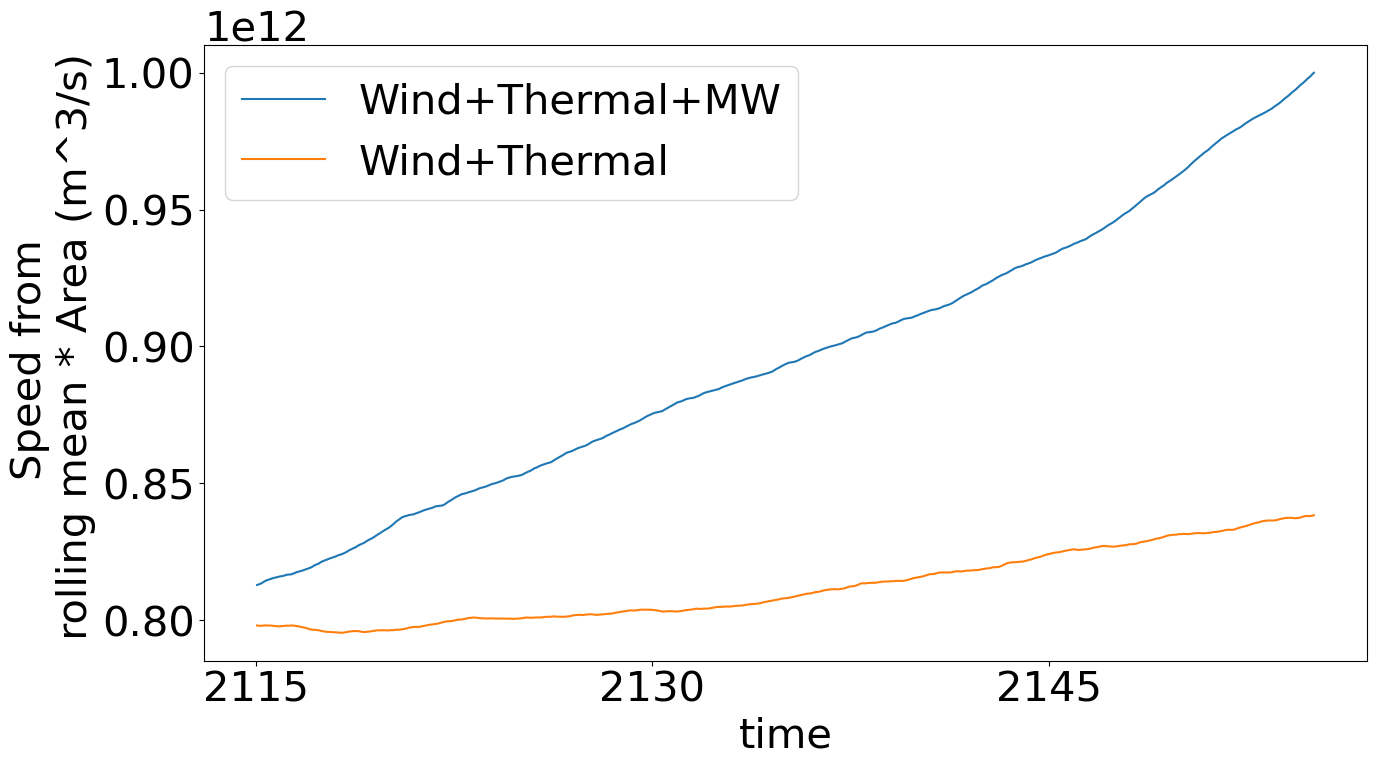

In [57]:
plt.figure(figsize = (15,8))
speed_t_wthmp.__xarray_dataarray_variable__.plot(label ='Wind+Thermal+MW')
speed_t_wthp.__xarray_dataarray_variable__.plot(label = 'Wind+Thermal')
plt.ylabel('Speed from \n rolling mean * Area (m^3/s)')
plt.legend()

In [58]:
speed_test.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/speed_t_rolling_W120_wthmp.nc')
speed_t_wthp.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/speed_t_rolling_W120_wthp.nc')

In [ ]:
## calculating EKE timeseries

In [55]:
FileList = ['/g/data/v45/qo9901/MW-perturb-ASC-data/EKEsurf_W'\
                + str(windows) + '_' + exp_wthmp + '_'+ str(xx_file)  +'_' + '{0:01}'.format(i) + '.nc' for xx_file in range(4) for i in range(3)]
EKE_rel_rolling = xr.open_mfdataset(FileList, combine = 'by_coords')

In [56]:
FileList

['/g/data/v45/qo9901/MW-perturb-ASC-data/EKEsurf_W120_01deg_jra55v13_ryf9091_qian_wthmp_0_0.nc',
 '/g/data/v45/qo9901/MW-perturb-ASC-data/EKEsurf_W120_01deg_jra55v13_ryf9091_qian_wthmp_0_1.nc',
 '/g/data/v45/qo9901/MW-perturb-ASC-data/EKEsurf_W120_01deg_jra55v13_ryf9091_qian_wthmp_0_2.nc',
 '/g/data/v45/qo9901/MW-perturb-ASC-data/EKEsurf_W120_01deg_jra55v13_ryf9091_qian_wthmp_1_0.nc',
 '/g/data/v45/qo9901/MW-perturb-ASC-data/EKEsurf_W120_01deg_jra55v13_ryf9091_qian_wthmp_1_1.nc',
 '/g/data/v45/qo9901/MW-perturb-ASC-data/EKEsurf_W120_01deg_jra55v13_ryf9091_qian_wthmp_1_2.nc',
 '/g/data/v45/qo9901/MW-perturb-ASC-data/EKEsurf_W120_01deg_jra55v13_ryf9091_qian_wthmp_2_0.nc',
 '/g/data/v45/qo9901/MW-perturb-ASC-data/EKEsurf_W120_01deg_jra55v13_ryf9091_qian_wthmp_2_1.nc',
 '/g/data/v45/qo9901/MW-perturb-ASC-data/EKEsurf_W120_01deg_jra55v13_ryf9091_qian_wthmp_2_2.nc',
 '/g/data/v45/qo9901/MW-perturb-ASC-data/EKEsurf_W120_01deg_jra55v13_ryf9091_qian_wthmp_3_0.nc',
 '/g/data/v45/qo9901/MW-pertur

In [58]:
EKE_rel_rolling_t = grid.integrate(EKE_rel_rolling, axis = {'X','Y'})

In [68]:
def EKEsurf(expt):
    FileList = ['/g/data/v45/qo9901/MW-perturb-ASC-data/EKEsurf_W'\
                    + str(windows) + '_' + expt + '_'+ str(xx_file)  +'_' + \
                '{0:01}'.format(i) + '.nc' for xx_file in range(4) for i in range(3)]
    EKE_rel_rolling = xr.open_mfdataset(FileList, combine = 'by_coords')
    EKE_rel_rolling_t = grid.integrate(EKE_rel_rolling.where(cluster_mask_access == True), axis = {'X','Y'}).load()
    return EKE_rel_rolling_t

In [69]:
EKE_wthmp = EKEsurf(exp_wthmp)
EKE_wthp = EKEsurf(exp_wthp)

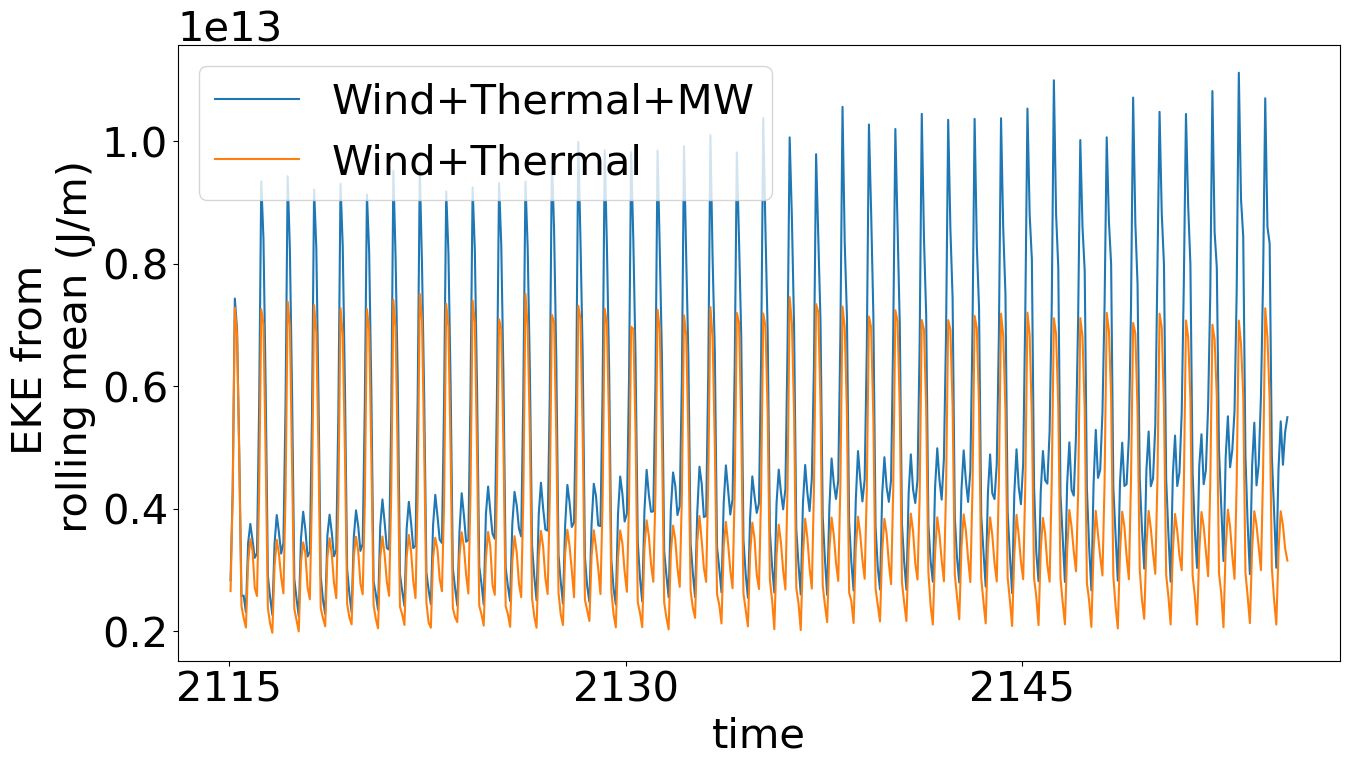

In [70]:
plt.figure(figsize = (15,8))
EKE_wthmp.__xarray_dataarray_variable__.plot(label = 'Wind+Thermal+MW')
EKE_wthp.__xarray_dataarray_variable__.plot(label = 'Wind+Thermal')
plt.ylabel('EKE from \n rolling mean (J/m)')
plt.legend()

In [73]:
def weighted_temporal_mean(ds):
    """
    weight by days in each month
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds.__xarray_dataarray_variable__
    
    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)
    

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out

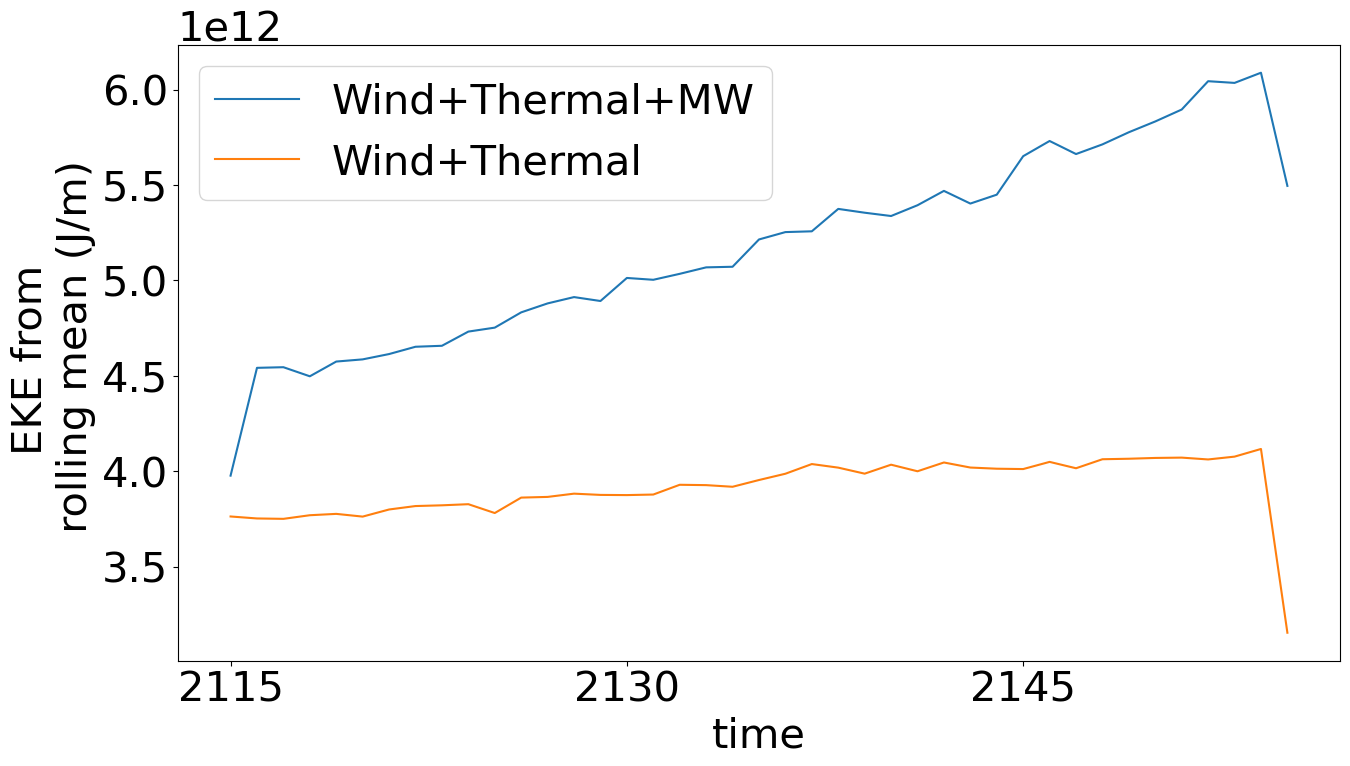

In [74]:
plt.figure(figsize = (15,8))
weighted_temporal_mean(EKE_wthmp).plot(label = 'Wind+Thermal+MW')
weighted_temporal_mean(EKE_wthp).plot(label = 'Wind+Thermal')
plt.ylabel('EKE from \n rolling mean (J/m)')
plt.legend()

In [75]:
EKE_wthp.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/EKE_t_rolling_W120_wthp.nc')
EKE_wthmp.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/EKE_t_rolling_W120_wthmp.nc')

In [83]:
cluster_mask_access = xr.open_mfdataset('Antarctic-Eddy-Res-Compare/largest_3cluster_mask_xr_accessom201.nc')
area_u = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='area_u', 
                          session=session, frequency='static',
                          attrs={'cell_methods': 'time: point'}, n=1).sel(xu_ocean= lon_lim, yu_ocean = lat_lim)

In [84]:
cluster_mask_access.load()

<xarray.Dataset> Size: 2MB
Dimensions:                        (yu_ocean: 440, xu_ocean: 3600)
Dimensions without coordinates: yu_ocean, xu_ocean
Data variables:
    __xarray_dataarray_variable__  (yu_ocean, xu_ocean) bool 2MB False ... False

In [87]:
mask_shelf = xr.where(hu<1000 , True, False)
mask_slope = xr.where(hu>1000, True, False)

In [88]:
## change masked region in question
region = 'Shelf region'
## Change the above line

if region == 'Slope region':
    mask_region = mask_slope
elif region == 'Shelf region':
    mask_region = mask_shelf


In [95]:
def EKEsurf_mask(expt, mask_region):
    FileList = ['/g/data/v45/qo9901/MW-perturb-ASC-data/EKEsurf_W'\
                    + str(windows) + '_' + expt + '_'+ str(xx_file)  +'_' + \
                '{0:01}'.format(i) + '.nc' for xx_file in range(4) for i in range(3)]
    EKE_rel_rolling = xr.open_mfdataset(FileList, combine = 'by_coords')
    circ_area = (area_u*cluster_mask_access.where(mask_region ==True)).sum().__xarray_dataarray_variable__.values    
    EKE_rel_rolling_t = grid.integrate(EKE_rel_rolling.where(cluster_mask_access == True)\
                                       .where(mask_region == True), axis = {'X','Y'}).load()/circ_area
    return EKE_rel_rolling_t

In [96]:
EKE_wthmp_slope = EKEsurf_mask(exp_wthmp, mask_slope)
EKE_wthp_slope = EKEsurf_mask(exp_wthp,mask_slope)

In [97]:
EKE_wthmp_shelf = EKEsurf_mask(exp_wthmp, mask_shelf)
EKE_wthp_shelf = EKEsurf_mask(exp_wthp,mask_shelf)

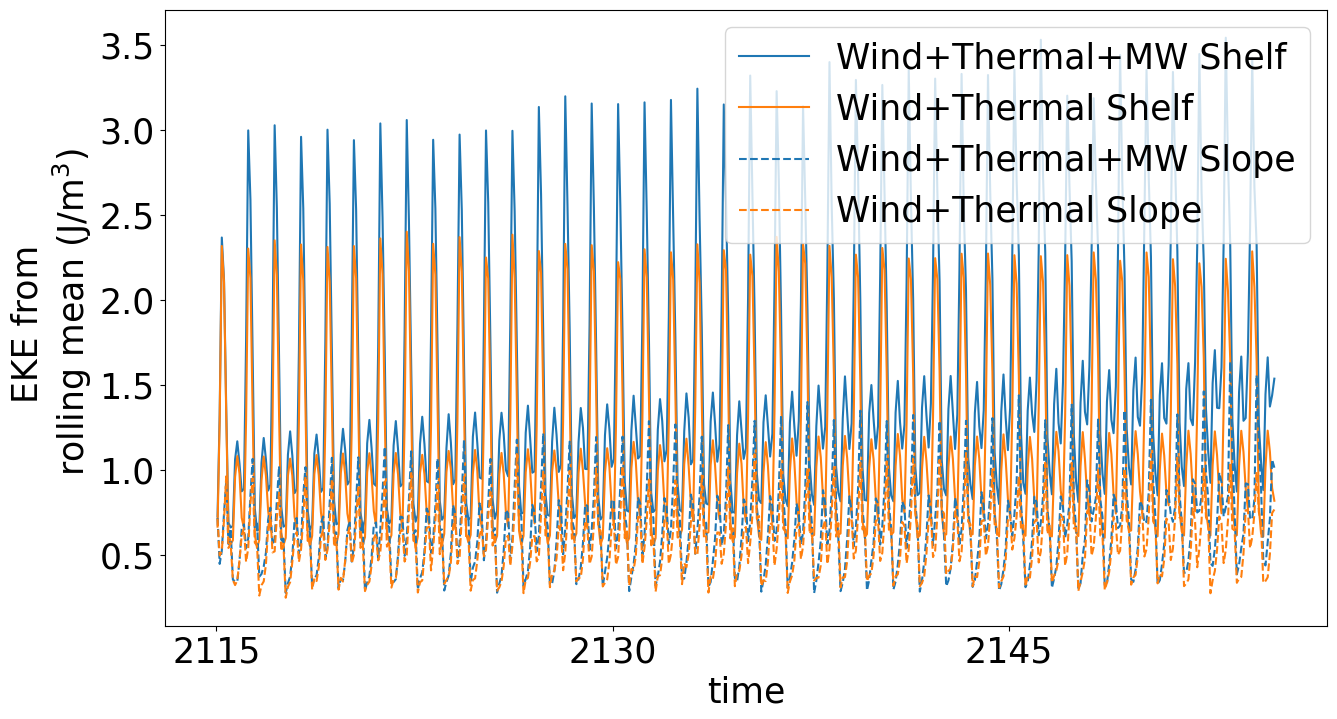

In [104]:
plt.figure(figsize = (15,8))
EKE_wthmp_shelf.__xarray_dataarray_variable__.plot(label = 'Wind+Thermal+MW Shelf')
EKE_wthp_shelf.__xarray_dataarray_variable__.plot(label = 'Wind+Thermal Shelf')
EKE_wthmp_slope.__xarray_dataarray_variable__.plot(label = 'Wind+Thermal+MW Slope', linestyle= 'dashed', color = 'C0')
EKE_wthp_slope.__xarray_dataarray_variable__.plot(label = 'Wind+Thermal Slope', linestyle= 'dashed', color = 'C1')
plt.ylabel('EKE from \n rolling mean (J/m$^{3}$)')
plt.legend()

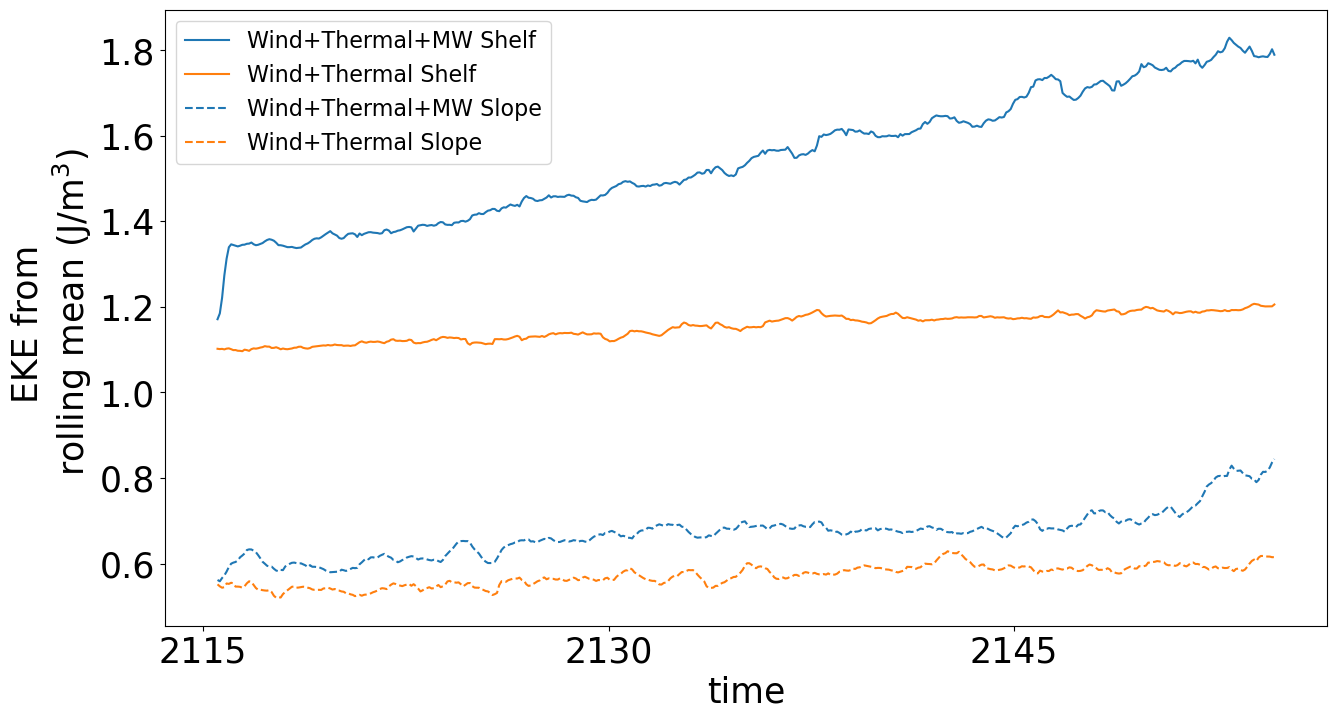

In [106]:
plt.figure(figsize = (15,8))
EKE_wthmp_shelf.__xarray_dataarray_variable__.rolling(time = 12, center = True).mean().plot(label = 'Wind+Thermal+MW Shelf')
EKE_wthp_shelf.__xarray_dataarray_variable__.rolling(time = 12, center = True).mean().plot(label = 'Wind+Thermal Shelf')
EKE_wthmp_slope.__xarray_dataarray_variable__.rolling(time = 12, center = True).mean().plot(label = 'Wind+Thermal+MW Slope', linestyle= 'dashed', color = 'C0')
EKE_wthp_slope.__xarray_dataarray_variable__.rolling(time = 12, center = True).mean().plot(label = 'Wind+Thermal Slope', linestyle= 'dashed', color = 'C1')
plt.ylabel('EKE from \n rolling mean (J/m$^{3}$)')
plt.legend(fontsize = 16)